# Flash drought decomposition reanalysis results

In [1]:
import glob as glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import sys
import os
import numpy as np
import time
import zarr
import matplotlib.pyplot as plt
import gc

In [2]:
sys.path.append('/g/data/mn51/users/jb6465/code/flash-drought/attribution-python')
from attribution import *
from plotting import *
from extract import *

In [3]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger("distributed.shuffle._scheduler_plugin").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    # 'array.chunk-size': "256 MiB",
    # 'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40277,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36369,Total threads: 1
Dashboard: /proxy/33849/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:43743,


## Compute $ET_0$ (reanalysis)

### BARRA-R2

In [17]:
%%time
for year in range(1979, 2025): 
    #mask ocean amd ingest ET0 inputs
    Rs = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/rsds/barra_domain_BARRAR2_{year}_rsds_day.nc').rsds)
    T = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/tas/barra_domain_BARRAR2_{year}_tas_day.nc').tas)
    Tmax = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/tasmax/barra_domain_BARRAR2_{year}_tasmax_day.nc').tasmax)
    Tmin = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/tasmin/barra_domain_BARRAR2_{year}_tasmin_day.nc').tasmin)
    Patm = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ps/barra_domain_BARRAR2_{year}_ps_day.nc').ps)
    Q2M = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/huss/barra_domain_BARRAR2_{year}_huss_day.nc').huss)
    W10M = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/sfcWind/barra_domain_BARRAR2_{year}_sfcWind_day.nc').sfcWind)
    elev =mask_ocean(xr.open_dataset(f'/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/orog/v20231001/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc').orog)

    #compute daily ET0 for full period
    ET0 = compute_ET0(Rs*86400, T-273.15, Tmax-273.15, Tmin-273.15, None, Patm, W10M, Q2M, None, None, None, elev,
                      derive_2m_windspeed=True, short_tall_crop_switch='tall', T2M_model_or_derived='derived', Patm_model_or_derived='model', esat_method='TmaxTmin', eact_method='Patm_q', Rnl_method='TmaxTmin')

    #save locally
    if not os.path.isfile(f"/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/ET0_tall_BARRAR2_{year}.nc"):
        os.makedirs("/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/", exist_ok=True)
        xr.Dataset({"ET0_tall_crop": ET0}).reset_coords(drop=True).to_netcdf(f"/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/ET0_tall_BARRAR2_{year}.nc", encoding={"ET0_tall_crop": {"zlib": True, "complevel": 5, "dtype": "float32"}})

CPU times: user 2h 13min 14s, sys: 1h 33min 57s, total: 3h 47min 11s
Wall time: 3h 50min 42s


### MERRA2

In [5]:
%%time
for year in range(1980, 2023): 
    #mask ocean amd ingest ET0 inputs
    Rs = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/SWGDN/barra_domain_MERRA2_{year}_SWGDN_day.nc').SWGDN)
    T = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/T2M_T2MDEW_QV2M_PS/barra_domain_MERRA2_{year}_T2M_T2MDEW_QV2M_PS_day.nc').T2M)
    Tdew = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/T2M_T2MDEW_QV2M_PS/barra_domain_MERRA2_{year}_T2M_T2MDEW_QV2M_PS_day.nc').T2MDEW)
    Tmax = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/T2M_MAX/barra_domain_MERRA2_{year}_T2M_MAX_day.nc').T2M)
    Tmin = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/T2M_MIN/barra_domain_MERRA2_{year}_T2M_MIN_day.nc').T2M)
    Patm = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/T2M_T2MDEW_QV2M_PS/barra_domain_MERRA2_{year}_T2M_T2MDEW_QV2M_PS_day.nc').PS)
    W2M = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/W2M/barra_domain_MERRA2_{year}_W2M_day.nc').W2M)
    Q2M = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/T2M_T2MDEW_QV2M_PS/barra_domain_MERRA2_{year}_T2M_T2MDEW_QV2M_PS_day.nc').QV2M)
    
    elevfile = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/MERRA2_101.const_2d_asm_Nx.nc4')
    geopot = elevfile['PHIS'].sel(lat=slice(domain_dict['barra_domain']['lat_min'], domain_dict['barra_domain']['lat_max']), lon=slice(domain_dict['barra_domain']['lon_min'], domain_dict['barra_domain']['lon_max']))
    elev = geopot[0]/9.81 #divide by 9.81m2/s to get elevation [m]
    
    #compute daily ET0 for full period
    ET0 = compute_ET0(Rs*86400, T-273.15, Tmax-273.15, Tmin-273.15, Tdew-273.15, Patm, W2M, Q2M, None, None, None, elev,
                      derive_2m_windspeed=False, short_tall_crop_switch='tall', T2M_model_or_derived='derived', Patm_model_or_derived='model', esat_method='TmaxTmin', eact_method='Patm_q', Rnl_method='TmaxTmin')

    #save locally
    if not os.path.isfile(f"/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/ET0/ET0_tall_MERRA2_{year}.nc"):
        os.makedirs("/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/ET0/", exist_ok=True)
        xr.Dataset({"ET0_tall_crop": ET0}).reset_coords(drop=True).to_netcdf(f"/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/ET0/ET0_tall_MERRA2_{year}.nc", encoding={"ET0_tall_crop": {"zlib": True, "complevel": 5, "dtype": "float32"}})

CPU times: user 7min 33s, sys: 1min 39s, total: 9min 12s
Wall time: 8min 2s


### ERA5

In [39]:
%%time
for year in range(1979, 2025): 
    #mask ocean amd ingest ET0 inputs
    Rs = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/ssrd/barra_domain_ERA5_{year}_ssrd_day.nc').ssrd)
    T = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/2t/barra_domain_ERA5_{year}_2t_day.nc').t2m)
    Tdew = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/2d/barra_domain_ERA5_{year}_2d_day.nc').d2m)
    Tmax = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/2tMax/barra_domain_ERA5_{year}_2tMax_day.nc').t2m)
    Tmin = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/2tMin/barra_domain_ERA5_{year}_2tMin_day.nc').t2m)
    Patm = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/sp/barra_domain_ERA5_{year}_sp_day.nc').sp)
    W10M = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/10w/barra_domain_ERA5_{year}_10w_day.nc').w10)
    Q2M = 0.622 * (6.112*100*np.exp(17.67*(Tdew-273.15)/((Tdew-273.15)+243.5))) / (Patm - 0.378*(6.112*100*np.exp(17.67*(Tdew-273.15)/((Tdew-273.15)+243.5))))
    elev = mask_ocean(xr.open_dataset(f'/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/orog/v20231001/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc').orog).interp_like(Rs[0])
    
    #compute daily ET0 for full period
    ET0 = compute_ET0(Rs, T-273.15, Tmax-273.15, Tmin-273.15, Tdew-273.15, Patm, W10M, Q2M, None, None, None, elev,
                      derive_2m_windspeed=True, short_tall_crop_switch='tall', T2M_model_or_derived='derived', Patm_model_or_derived='model', esat_method='TmaxTmin', eact_method='Patm_q', Rnl_method='TmaxTmin')

    #save locally
    if not os.path.isfile(f"/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/ET0/ET0_tall_ERA5_{year}.nc"):
        os.makedirs("/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/ET0/", exist_ok=True)
        xr.Dataset({"ET0_tall_crop": ET0}).reset_coords(drop=True).to_netcdf(f"/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/ET0/ET0_tall_ERA5_{year}.nc", encoding={"ET0_tall_crop": {"zlib": True, "complevel": 5, "dtype": "float32"}})

CPU times: user 28min 50s, sys: 13min 2s, total: 41min 53s
Wall time: 36min 18s


## $ET_0$ means, variabilities and contributions

In [5]:
warnings.filterwarnings("ignore", message="invalid value encountered in divide", category=RuntimeWarning)

In [17]:
BARRA_ET0 = xr.open_mfdataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/*.nc').chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).ET0_tall_crop.sortby('time').sel(time=slice('1980', '2022'))
BARRA_ET0_mean = ((BARRA_ET0.assign_coords(doy=BARRA_ET0['time'].dt.dayofyear).groupby('doy').mean('time')).mean(dim='doy')).compute()
BARRA_ET0_var = ((BARRA_ET0.assign_coords(doy=BARRA_ET0['time'].dt.dayofyear).groupby('doy').mean('time')).var(dim='doy')).compute()

ERA5_ET0 = xr.open_mfdataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/ERA5/ET0/*.nc').chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).ET0_tall_crop.sortby('time').sel(time=slice('1980', '2022'))
ERA5_ET0_mean = ((ERA5_ET0.assign_coords(doy=ERA5_ET0['time'].dt.dayofyear).groupby('doy').mean('time')).mean(dim='doy')).compute()
ERA5A_ET0_var = ((ERA5_ET0.assign_coords(doy=ERA5_ET0['time'].dt.dayofyear).groupby('doy').mean('time')).var(dim='doy')).compute()

MERRA2_ET0 = xr.open_mfdataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/ET0/*.nc').chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).ET0_tall_crop.sortby('time').sel(time=slice('1980', '2022'))
MERRA2_ET0_mean = ((MERRA2_ET0.assign_coords(doy=MERRA2_ET0['time'].dt.dayofyear).groupby('doy').mean('time')).mean(dim='doy')).compute()
MERRA2_ET0_var = ((MERRA2_ET0.assign_coords(doy=MERRA2_ET0['time'].dt.dayofyear).groupby('doy').mean('time')).var(dim='doy')).compute()

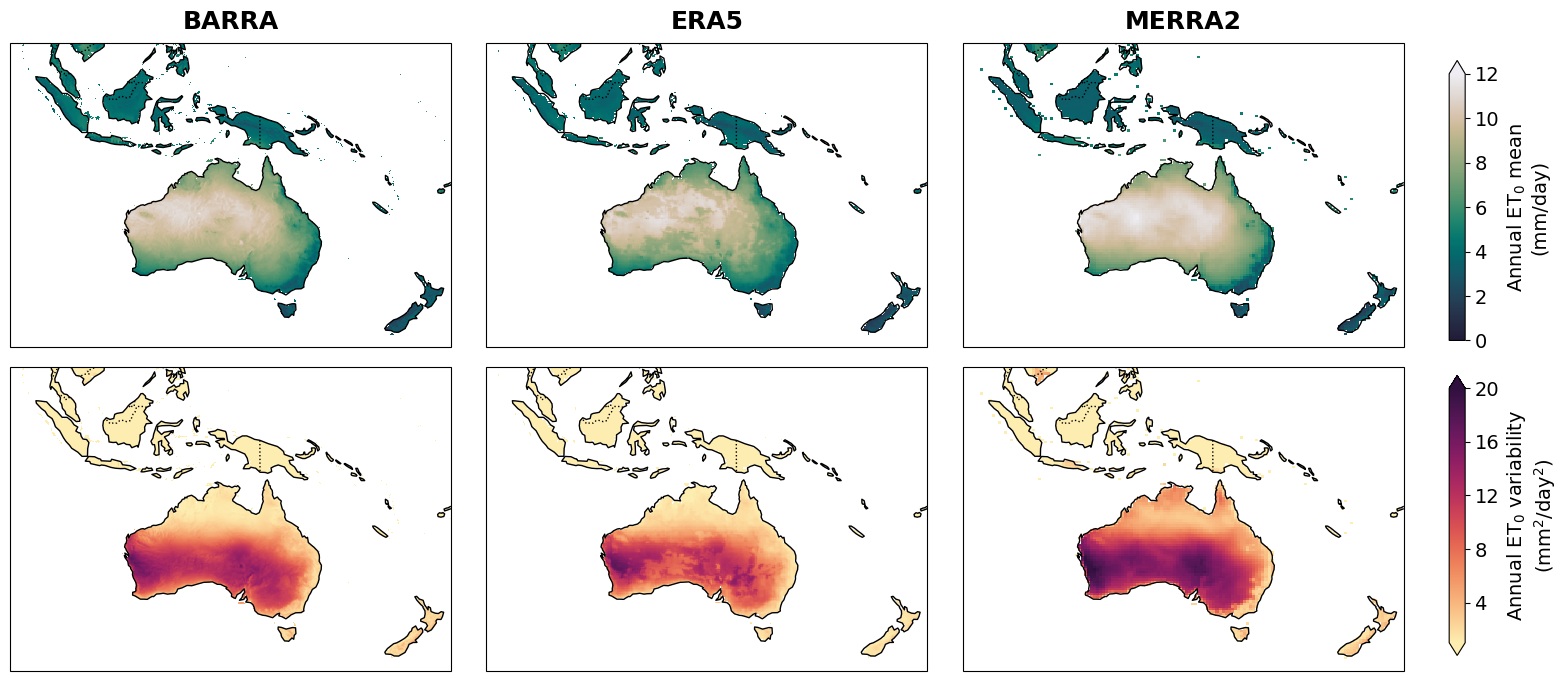

In [7]:
import cmocean

create_multiplot(nrows=2, ncols=3, plot_fontsize=14, title_size=18, figsize=(16, 7), plot_extent=[90, 180, -40, 9],
    plot_list=[[BARRA_ET0_mean, ERA5_ET0_mean, MERRA2_ET0_mean], [BARRA_ET0_var, ERA5A_ET0_var, MERRA2_ET0_var]],
    shapefile = None,
    shapefile_linewidth = None,
    col_titles=['BARRA', 'ERA5', 'MERRA2'],
    col_titles_all_rows_switch=False,
    cmap_list=[cmocean.cm.rain_r, cmocean.cm.matter],
    cbar_labels=['Annual ET$_0$ mean\n(mm/day)', 'Annual ET$_0$ variability\n(mm$^2$/day$^2$)'],
    cbar_extensions=['max','both'],
    cbar_width=0.01,
    cbar_height = 0.4,
    cbar_nticks=[7,5],
    cbar_x_y_loc = (0.92, 0.05 + 0.45),
    cbar_mins=[0,1],
    cbar_maxs=[12,20])

## $ET_0$ driver sensitivities

##### only need to compute once and save locally

In [8]:
%%time
barra_root_dir = '/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2'
R = xr.open_mfdataset(f'{barra_root_dir}/rsds/*.nc').rsds.chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
T = 0.5*(xr.open_mfdataset(f'{barra_root_dir}/tasmin/*.nc').tasmin+xr.open_mfdataset(f'{barra_root_dir}/tasmax/*.nc').tasmax).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
q = xr.open_mfdataset(f'{barra_root_dir}/huss/*.nc').huss.chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
U = (xr.open_mfdataset(f'{barra_root_dir}/sfcWind/*.nc').sfcWind * (4.87 / np.log(67.8 * 10.0 - 5.42))).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
Patm = xr.open_mfdataset(f'{barra_root_dir}/ps/*.nc').ps.chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

CPU times: user 17.4 s, sys: 8.65 s, total: 26 s
Wall time: 38.6 s


compute DOY 7-day smoothed means for sensitivity calculations

In [6]:
R_climo = compute_doy_climo(compute_rolling_xday(R*86400, 7, centre_window=True))
T_climo = compute_doy_climo(compute_rolling_xday(T-273.15, 7, centre_window=True))
q_climo = compute_doy_climo(compute_rolling_xday(q, 7, centre_window=True))
U_climo = compute_doy_climo(compute_rolling_xday(U, 7, centre_window=True))
Patm_climo = compute_doy_climo(compute_rolling_xday(Patm, 7, centre_window=True))

In [7]:
elev = xr.open_dataset(f'/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/orog/v20231001/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc').orog

compute sensitvities and write locally

In [8]:
%%time
sens_T, sens_R, sens_q, sens_U = compute_driver_sensivities(R_climo,T_climo,U_climo,q_climo,Patm_climo,elev,
                                                            short_tall_crop_switch = 'tall')

CPU times: user 1min 5s, sys: 15.2 s, total: 1min 20s
Wall time: 2min 39s


In [9]:
%%time
save_dir = '/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_sensitivities'
sensitivity_key = ['sens_T', 'sens_R', 'sens_q', 'sens_U']
units = ['(mm/day)/(K)', '(mm/day)/(W/m2)', '(mm/day)/(kg/kg)', '(mm/day)/(m/s)']

for i, driver_sensitivity in enumerate([sens_T, sens_R, sens_q, sens_U]):
    start = time.time()
    saver = xr.Dataset({f"{sensitivity_key[i]}": driver_sensitivity.assign_attrs(long_name=f"{sensitivity_key[i][-1]} driver sensitvity", units=str(units[i]))}).reset_coords(drop=True).astype('float32').to_zarr(f"{save_dir}/{sensitivity_key[i]}.zarr", mode="w", consolidated=True, encoding={f"{sensitivity_key[i]}": {"compressor": zarr.Blosc(cname='zstd', clevel=5, shuffle=1)}})
    end = time.time()
    print(f"~ {sensitivity_key[i][-1]} driver sensitivity computed in {end - start:.2f} s")

~ T driver sensitivity computed in 676.65 s
~ R driver sensitivity computed in 526.46 s
~ q driver sensitivity computed in 527.79 s
~ U driver sensitivity computed in 675.59 s
CPU times: user 16min 39s, sys: 1min 48s, total: 18min 28s
Wall time: 40min 6s


##### plotting

In [5]:
sens_T = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_sensitivities/sens_T.zarr').sens_T
sens_R = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_sensitivities/sens_R.zarr').sens_R
sens_q = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_sensitivities/sens_q.zarr').sens_q
sens_U = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_sensitivities/sens_U.zarr').sens_U

In [6]:
idx = lambda m: pd.Timestamp(f"2001-{m}-01").dayofyear - 1
print(idx("May"))
print(idx("Nov"))

120
304


In [7]:
%%time
MJASSO_sens_T = mask_ocean(sens_T.isel(doy=slice(120, 304)).mean(dim="doy"))
MJASSO_sens_R = mask_ocean(sens_R.isel(doy=slice(120, 304)).mean(dim="doy"))
MJASSO_sens_q = mask_ocean(sens_q.isel(doy=slice(120, 304)).mean(dim="doy"))
MJASSO_sens_U = mask_ocean(sens_U.isel(doy=slice(120, 304)).mean(dim="doy"))

NDJFMA_sens_T = mask_ocean(xr.concat([sens_T.isel(doy=slice(304,None)), sens_T.isel(doy=slice(0,120))], "doy").mean("doy"))
NDJFMA_sens_R = mask_ocean(xr.concat([sens_R.isel(doy=slice(304,None)), sens_R.isel(doy=slice(0,120))], "doy").mean("doy"))
NDJFMA_sens_q = mask_ocean(xr.concat([sens_q.isel(doy=slice(304,None)), sens_q.isel(doy=slice(0,120))], "doy").mean("doy"))
NDJFMA_sens_U = mask_ocean(xr.concat([sens_U.isel(doy=slice(304,None)), sens_U.isel(doy=slice(0,120))], "doy").mean("doy"))


CPU times: user 1min 19s, sys: 29.7 s, total: 1min 48s
Wall time: 2min 11s


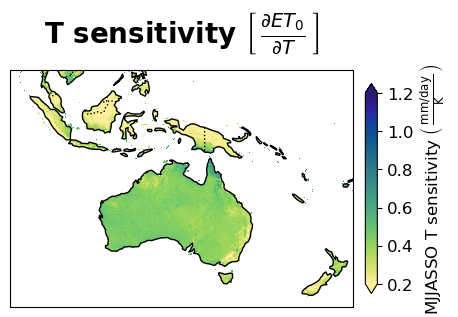

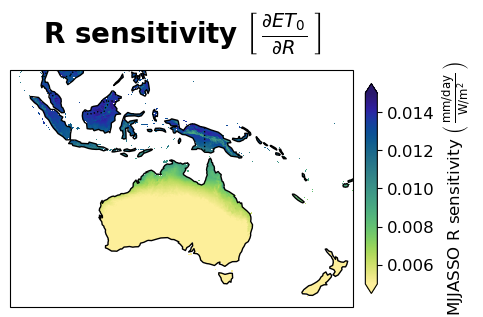

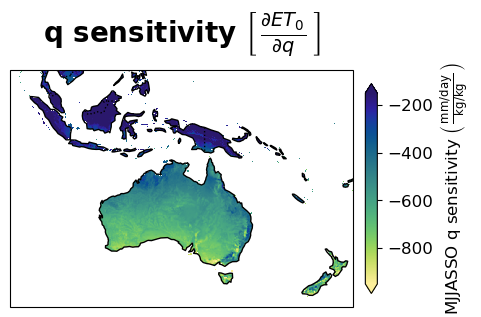

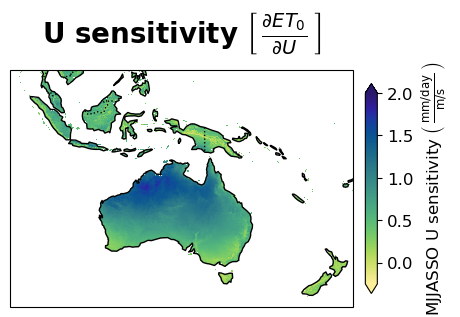

In [8]:
import cmocean
plot_titles = ["T sensitivity " + r"$\left[\,\frac{\partial ET_0}{\partial T}\,\right]$",
              "R sensitivity " + r"$\left[\,\frac{\partial ET_0}{\partial R}\,\right]$",
              "q sensitivity " + r"$\left[\,\frac{\partial ET_0}{\partial q}\,\right]$",
              "U sensitivity " + r"$\left[\,\frac{\partial ET_0}{\partial U}\,\right]$"]

units = ["MJJASSO T sensitivity " + r"$\left(\,\frac{\mathrm{mm/day}}{\mathrm{K}}\,\right)$",
        "MJJASSO R sensitivity " + r"$\left(\,\frac{\mathrm{mm/day}}{\mathrm{W/m^2}}\,\right)$",
        "MJJASSO q sensitivity " + r"$\left(\,\frac{\mathrm{mm/day}}{\mathrm{kg/kg}}\,\right)$",
        "MJJASSO U sensitivity " + r"$\left(\,\frac{\mathrm{mm/day}}{\mathrm{m/s}}\,\right)$"]

maxs = [1.2, 0.015, -150, 2]
mins = [0.2, 0.005, -950, -0.25 ]
for plot_idx, plot_array in enumerate([MJASSO_sens_T, MJASSO_sens_R, MJASSO_sens_q, MJASSO_sens_U]):
    create_multiplot(nrows=1, ncols=1, plot_fontsize=12, title_size=20, figsize=(4, 6), plot_extent=[90, 180, -40, 9],
        plot_list=[[plot_array]],
        shapefile = None,
        shapefile_linewidth = None,
        col_titles=[plot_titles[plot_idx]],
        col_titles_all_rows_switch=False,
        cmap_list=[cmocean.cm.haline_r],
        cbar_labels=[units[plot_idx]],
        cbar_extensions=['both'],
        cbar_width = 0.03,
        cbar_height = 0.35,
        cbar_nticks = [5],
        cbar_x_y_loc = (0.93, 0.65/2),
        cbar_mins=[mins[plot_idx]],
        cbar_maxs=[maxs[plot_idx]])

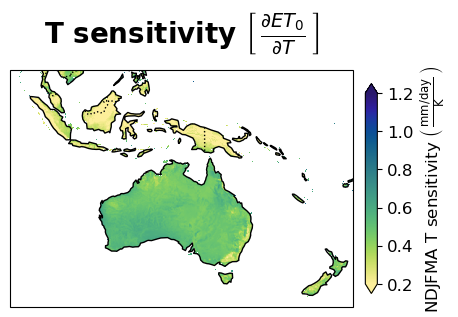

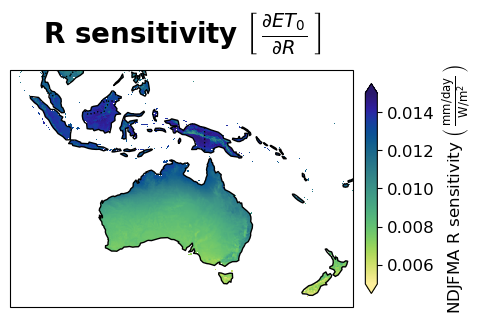

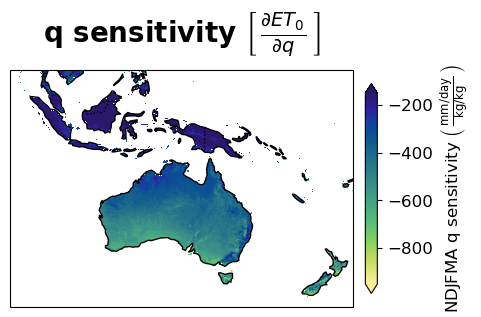

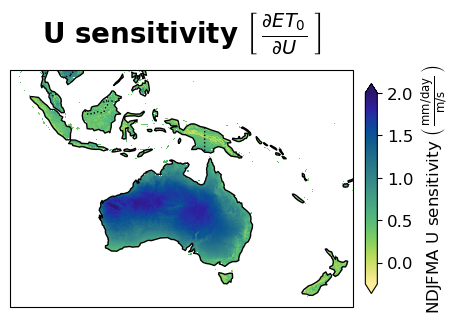

In [9]:
import cmocean
plot_titles = ["T sensitivity " + r"$\left[\,\frac{\partial ET_0}{\partial T}\,\right]$",
              "R sensitivity " + r"$\left[\,\frac{\partial ET_0}{\partial R}\,\right]$",
              "q sensitivity " + r"$\left[\,\frac{\partial ET_0}{\partial q}\,\right]$",
              "U sensitivity " + r"$\left[\,\frac{\partial ET_0}{\partial U}\,\right]$"]

units = ["NDJFMA T sensitivity " + r"$\left(\,\frac{\mathrm{mm/day}}{\mathrm{K}}\,\right)$",
        "NDJFMA R sensitivity " + r"$\left(\,\frac{\mathrm{mm/day}}{\mathrm{W/m^2}}\,\right)$",
        "NDJFMA q sensitivity " + r"$\left(\,\frac{\mathrm{mm/day}}{\mathrm{kg/kg}}\,\right)$",
        "NDJFMA U sensitivity " + r"$\left(\,\frac{\mathrm{mm/day}}{\mathrm{m/s}}\,\right)$"]

maxs = [1.2, 0.015, -150, 2]
mins = [0.2, 0.005, -950, -0.25 ]
for plot_idx, plot_array in enumerate([NDJFMA_sens_T, NDJFMA_sens_R, NDJFMA_sens_q, NDJFMA_sens_U]):
    create_multiplot(nrows=1, ncols=1, plot_fontsize=12, title_size=20, figsize=(4, 6), plot_extent=[90, 180, -40, 9],
        plot_list=[[plot_array]],
        shapefile = None,
        shapefile_linewidth = None,
        col_titles=[plot_titles[plot_idx]],
        col_titles_all_rows_switch=False,
        cmap_list=[cmocean.cm.haline_r],
        cbar_labels=[units[plot_idx]],
        cbar_extensions=['both'],
        cbar_width = 0.03,
        cbar_height = 0.35,
        cbar_nticks = [5],
        cbar_x_y_loc = (0.93, 0.65/2),
        cbar_mins=[mins[plot_idx]],
        cbar_maxs=[maxs[plot_idx]])

## $ET_0$ driver contributions

In [6]:
barra_root_dir = '/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2'

ET0 = xr.open_mfdataset(f'{barra_root_dir}/ET0/*.nc').ET0_tall_crop.chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
R = xr.open_mfdataset(f'{barra_root_dir}/rsds/*.nc').rsds.chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
T = 0.5*(xr.open_mfdataset(f'{barra_root_dir}/tasmin/*.nc').tasmin+xr.open_mfdataset(f'{barra_root_dir}/tasmax/*.nc').tasmax).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
q = xr.open_mfdataset(f'{barra_root_dir}/huss/*.nc').huss.chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
U = (xr.open_mfdataset(f'{barra_root_dir}/sfcWind/*.nc').sfcWind * (4.87 / np.log(67.8 * 10.0 - 5.42))).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

In [7]:
ET0_anom = compute_daily_anom(compute_rolling_xday(ET0, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
T_anom = compute_daily_anom(compute_rolling_xday(T, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
R_anom = compute_daily_anom(compute_rolling_xday(R, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
q_anom = compute_daily_anom(compute_rolling_xday(q, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
U_anom = compute_daily_anom(compute_rolling_xday(U, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

In [8]:
%%time
T_cont = (T_anom*sens_T.sel(doy=T_anom['time'].dt.dayofyear)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
R_cont = (R_anom*sens_R.sel(doy=R_anom['time'].dt.dayofyear)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
q_cont = (q_anom*sens_q.sel(doy=q_anom['time'].dt.dayofyear)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
U_cont = (U_anom*sens_U.sel(doy=U_anom['time'].dt.dayofyear)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

CPU times: user 20min 16s, sys: 3min 34s, total: 23min 50s
Wall time: 20min 2s


In [9]:
%%time
save_dir = '/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_contributions'
contribution_key = ['cont_T', 'cont_R', 'cont_q', 'cont_U']

for i, driver_contribution in enumerate([T_cont, R_cont, q_cont, U_cont]):
    start = time.time()
    driver_contribution = driver_contribution.reset_coords(drop=True)
    saver = xr.Dataset({f"{contribution_key[i]}": driver_contribution.assign_attrs(long_name=f"{contribution_key[i][-1]} driver contribution", units="mm")}).reset_coords(drop=True).astype('float32').to_zarr(f"{save_dir}/{contribution_key[i]}.zarr", mode="w", consolidated=True, encoding={f"{contribution_key[i]}": {"compressor": zarr.Blosc(cname='zstd', clevel=5, shuffle=1)}})
    end = time.time()
    print(f"~ {contribution_key[i][-1]} driver contribution computed in {end - start:.2f} s")

~ T driver contribution computed in 548.40 s
~ R driver contribution computed in 505.79 s
~ q driver contribution computed in 497.32 s
~ U driver contribution computed in 527.45 s
CPU times: user 14min 47s, sys: 5min 52s, total: 20min 40s
Wall time: 34min 38s


In [11]:
T_cont = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_contributions/cont_T.zarr').cont_T
R_cont = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_contributions/cont_R.zarr').cont_R
q_cont = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_contributions/cont_q.zarr').cont_q
U_cont = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_contributions/cont_U.zarr').cont_U

In [13]:
T_cont.sel(time=T_cont.time.dt.month.isin([5,6,7,8,9,10])).groupby("time.year").sum(dim="time").mean('year').plot()

<xarray.DataArray 'cont_T' (year: 46, lat: 646, lon: 1082)> Size: 129MB
array([[[  47.074806  ,   47.22958   ,   46.83515   , ...,
           62.93998   ,   62.70575   ,   62.748833  ],
        [  45.858902  ,   45.97706   ,   45.573376  , ...,
           63.40365   ,   63.45813   ,   63.602478  ],
        [  44.69096   ,   44.503735  ,   44.6932    , ...,
           64.20979   ,   64.090965  ,   64.088455  ],
        ...,
        [   6.33235   ,    6.021368  ,    5.5673842 , ...,
           -0.77058244,   -2.0469303 ,   -3.64944   ],
        [   7.8264546 ,    7.6476307 ,    6.5338774 , ...,
           -1.3148441 ,   -2.3419087 ,   -3.6888871 ],
        [   8.872222  ,    8.8396015 ,    8.2675905 , ...,
           -1.9978632 ,   -2.8752072 ,   -4.290481  ]],

       [[ -41.13989   ,  -41.20995   ,  -41.540096  , ...,
            2.7487788 ,    4.3925676 ,    6.2499695 ],
        [ -40.698044  ,  -40.984997  ,  -41.076042  , ...,
            2.506448  ,    3.823315  ,    5.668166  ],
        [ -40.43464   ,  -40.938644  ,  -40.87071   , ...,
            1.0428672 ,    2.578893  ,    4.3290315 ],
...
        [  65.315216  ,   63.43272   ,   61.836853  , ...,
           -9.977867  ,   -8.547235  ,   -6.5012507 ],
        [  65.34542   ,   63.144615  ,   61.932335  , ...,
          -10.638037  ,   -8.957993  ,   -7.260963  ],
        [  65.66942   ,   63.279037  ,   61.347515  , ...,
          -11.336498  ,   -9.727498  ,   -7.724562  ]],

       [[  49.753044  ,   49.34476   ,   49.30299   , ...,
           35.446903  ,   36.5075    ,   38.333736  ],
        [  49.659363  ,   49.22294   ,   49.059555  , ...,
           34.28148   ,   35.351044  ,   36.951904  ],
        [  49.064293  ,   48.871063  ,   48.8439    , ...,
           34.08197   ,   35.361416  ,   36.680935  ],
        ...,
        [ 117.38725   ,  117.878845  ,  117.86984   , ...,
           46.984097  ,   47.681103  ,   48.581005  ],
        [ 116.90889   ,  116.56121   ,  116.76396   , ...,
           48.554546  ,   49.152946  ,   49.275864  ],
        [ 116.50079   ,  115.794846  ,  115.78465   , ...,
           50.28656   ,   50.57473   ,   50.56688   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 5kB -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 9kB 88.48 88.59 88.7 88.81 ... 207.2 207.3 207.4
  * year     (year) int64 368B 1979 1980 1981 1982 1983 ... 2021 2022 2023 2024
Attributes:
    long_name:  T driver contribution
    units:      mm

## Black summer case study

In [5]:
# load in drivers selecting only years 2015-2021
barra_root_dir = '/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2'

ET0 = xr.open_mfdataset(f'{barra_root_dir}/ET0/*.nc').ET0_tall_crop.chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).sel(time=slice('2015', '2021'))
R = xr.open_mfdataset(f'{barra_root_dir}/rsds/*.nc').rsds.chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).sel(time=slice('2015', '2021'))
T = 0.5*(xr.open_mfdataset(f'{barra_root_dir}/tasmin/*.nc').tasmin+xr.open_mfdataset(f'{barra_root_dir}/tasmax/*.nc').tasmax).chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).sel(time=slice('2015', '2021'))
q = xr.open_mfdataset(f'{barra_root_dir}/huss/*.nc').huss.chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).sel(time=slice('2015', '2021'))
U = (xr.open_mfdataset(f'{barra_root_dir}/sfcWind/*.nc').sfcWind * (4.87 / np.log(67.8 * 10.0 - 5.42))).chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).sel(time=slice('2015', '2021'))

# load in sensitivities
sens_T = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_sensitivities/sens_T.zarr').sens_T
sens_R = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_sensitivities/sens_R.zarr').sens_R
sens_q = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_sensitivities/sens_q.zarr').sens_q
sens_U = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/BARRA-R2/ET0/driver_sensitivities/sens_U.zarr').sens_U

In [6]:
%%time
ET0_anom = compute_daily_anom(compute_rolling_xday(ET0, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).compute()
T_anom = compute_daily_anom(compute_rolling_xday(T, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).compute()
R_anom = compute_daily_anom(compute_rolling_xday(R, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).compute()
q_anom = compute_daily_anom(compute_rolling_xday(q, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).compute()
U_anom = compute_daily_anom(compute_rolling_xday(U, 7, True)).chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).compute()

CPU times: user 7min 55s, sys: 1min 51s, total: 9min 46s
Wall time: 14min 41s


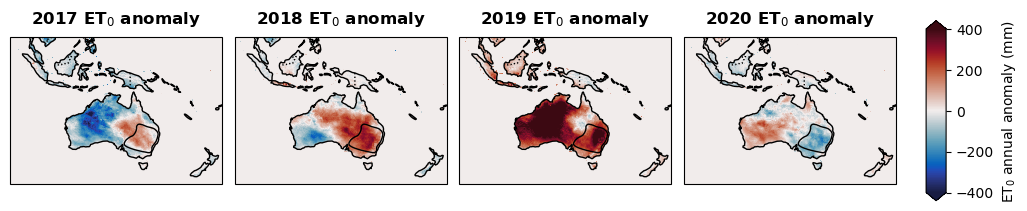

In [11]:
import cmocean
create_multiplot(nrows=1, ncols=4, plot_fontsize=10, title_size=12, figsize=(10, 12), plot_extent=[90, 180, -40, 9],
        plot_list=[[ET0_anom.sel(time='2017').sum(dim='time'),ET0_anom.sel(time='2018').sum(dim='time'), ET0_anom.sel(time='2019').sum(dim='time'), ET0_anom.sel(time='2020').sum(dim='time')]],
        shapefile = '/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp',
        shapefile_linewidth = 1,
        col_titles=['2017 ET$_0$ anomaly', '2018 ET$_0$ anomaly', '2019 ET$_0$ anomaly', '2020 ET$_0$ anomaly'],
        col_titles_all_rows_switch=False,
        cmap_list=[cmocean.cm.balance],
        cbar_labels=['ET$_0$ annual anomaly (mm)'],
        cbar_extensions=['both'],
        cbar_width = 0.02,
        cbar_height = 0.15,
        cbar_nticks = [5],
        cbar_x_y_loc = (0.93, 0.85/2),
        cbar_mins=[-400],
        cbar_maxs=[400])

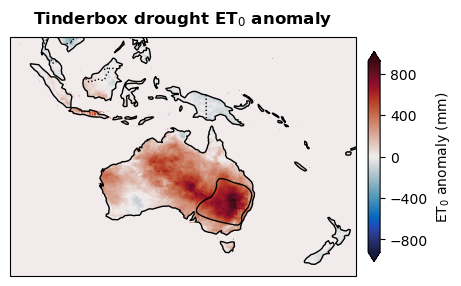

In [12]:
create_multiplot(nrows=1, ncols=1, plot_fontsize=10, title_size=12, figsize=(4, 6), plot_extent=[90, 180, -40, 9],
        shapefile = '/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp',
        shapefile_linewidth = 1,
        plot_list=[[ET0_anom.sel(time=slice('2017', '2019')).sum(dim='time')]],
        col_titles=['Tinderbox drought ET$_0$ anomaly'],
        col_titles_all_rows_switch=False,
        cmap_list=[cmocean.cm.balance],
        cbar_labels=['ET$_0$ anomaly (mm)'],
        cbar_extensions=['both'],
        cbar_width = 0.03,
        cbar_height = 0.35,
        cbar_nticks = [5],
        cbar_x_y_loc = (0.93, 0.65/2),
        cbar_mins=[None],
        cbar_maxs=[None])

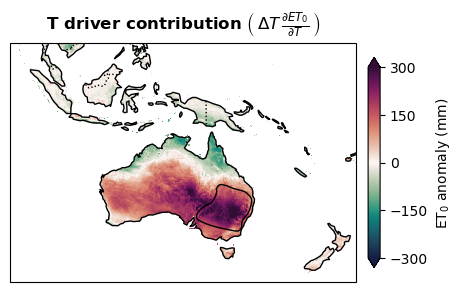

In [29]:
T_cont = mask_ocean((T_anom*sens_T.sel(doy=T_anom['time'].dt.dayofyear)).sel(time=slice('2017','2019')).sum(dim='time'))

create_multiplot(nrows=1, ncols=1, plot_fontsize=10, title_size=12, figsize=(4, 6), plot_extent=[90, 180, -40, 9],
        shapefile = '/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp',
        shapefile_linewidth = 1,
        plot_list=[[T_cont]],
        col_titles=['T driver contribution ' + r"$\left(\,\Delta T\,\frac{\partial ET_0}{\partial T}\,\right)$"],
        col_titles_all_rows_switch=False,
        cmap_list=[cmocean.cm.curl],
        cbar_labels=['ET$_0$ anomaly (mm)'],
        cbar_extensions=['both'],
        cbar_width = 0.03,
        cbar_height = 0.35,
        cbar_nticks = [5],
        cbar_x_y_loc = (0.93, 0.65/2),
        cbar_mins=[-300],
        cbar_maxs=[300])

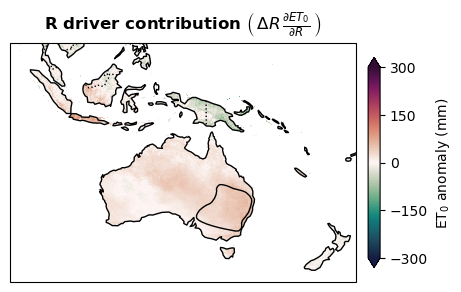

In [30]:
R_cont = mask_ocean((R_anom*sens_R.sel(doy=R_anom['time'].dt.dayofyear)).sel(time=slice('2017','2019')).sum(dim='time'))

create_multiplot(nrows=1, ncols=1, plot_fontsize=10, title_size=12, figsize=(4, 6), plot_extent=[90, 180, -40, 9],
        shapefile = '/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp',
        shapefile_linewidth = 1,
        plot_list=[[R_cont]],
        col_titles=['R driver contribution ' + r"$\left(\,\Delta R\,\frac{\partial ET_0}{\partial R}\,\right)$"],
        col_titles_all_rows_switch=False,
        cmap_list=[cmocean.cm.curl],
        cbar_labels=['ET$_0$ anomaly (mm)'],
        cbar_extensions=['both'],
        cbar_width = 0.03,
        cbar_height = 0.35,
        cbar_nticks = [5],
        cbar_x_y_loc = (0.93, 0.65/2),
        cbar_mins=[-300],
        cbar_maxs=[300])

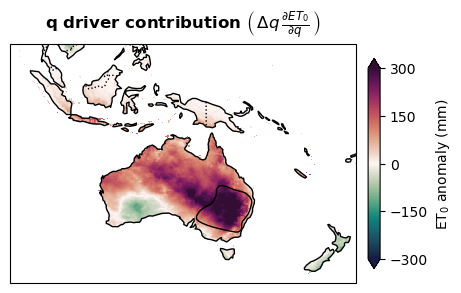

In [31]:
q_cont = mask_ocean((q_anom*sens_q.sel(doy=q_anom['time'].dt.dayofyear)).sel(time=slice('2017','2019')).sum(dim='time'))

create_multiplot(nrows=1, ncols=1, plot_fontsize=10, title_size=12, figsize=(4, 6), plot_extent=[90, 180, -40, 9],
        shapefile = '/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp',
        shapefile_linewidth = 1,
        plot_list=[[q_cont]],
        col_titles=['q driver contribution ' + r"$\left(\,\Delta q\,\frac{\partial ET_0}{\partial q}\,\right)$"],
        col_titles_all_rows_switch=False,
        cmap_list=[cmocean.cm.curl],
        cbar_labels=['ET$_0$ anomaly (mm)'],
        cbar_extensions=['both'],
        cbar_width = 0.03,
        cbar_height = 0.35,
        cbar_nticks = [5],
        cbar_x_y_loc = (0.93, 0.65/2),
        cbar_mins=[-300],
        cbar_maxs=[300])

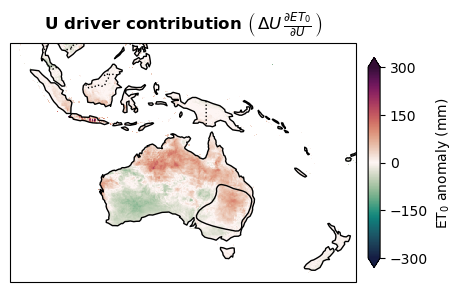

In [32]:
U_cont = mask_ocean((U_anom*sens_U.sel(doy=U_anom['time'].dt.dayofyear)).sel(time=slice('2017','2019')).sum(dim='time'))

create_multiplot(nrows=1, ncols=1, plot_fontsize=10, title_size=12, figsize=(4, 6), plot_extent=[90, 180, -40, 9],
        shapefile = '/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp',
        shapefile_linewidth = 1,
        plot_list=[[U_cont]],
        col_titles=['U driver contribution ' + r"$\left(\,\Delta U\,\frac{\partial ET_0}{\partial U}\,\right)$"],
        col_titles_all_rows_switch=False,
        cmap_list=[cmocean.cm.curl],
        cbar_labels=['ET$_0$ anomaly (mm)'],
        cbar_extensions=['both'],
        cbar_width = 0.03,
        cbar_height = 0.35,
        cbar_nticks = [5],
        cbar_x_y_loc = (0.93, 0.65/2),
        cbar_mins=[-300],
        cbar_maxs=[300])

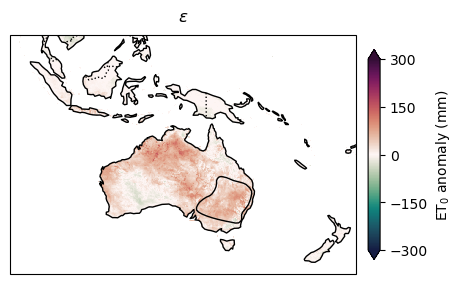

In [36]:
closure = ET0_anom.sel(time=slice('2017', '2019')).sum(dim='time') - (T_cont + R_cont + q_cont + U_cont)
create_multiplot(nrows=1, ncols=1, plot_fontsize=10, title_size=12, figsize=(4, 6), plot_extent=[90, 180, -40, 9],
        shapefile = '/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp',
        shapefile_linewidth = 1,
        plot_list=[[closure]],
        col_titles=[r"$\varepsilon$"],
        col_titles_all_rows_switch=False,
        cmap_list=[cmocean.cm.curl],
        cbar_labels=['ET$_0$ anomaly (mm)'],
        cbar_extensions=['both'],
        cbar_width = 0.03,
        cbar_height = 0.35,
        cbar_nticks = [5],
        cbar_x_y_loc = (0.93, 0.65/2),
        cbar_mins=[-300],
        cbar_maxs=[300])

In [43]:
import rioxarray
import geopandas as gpd

ET0_anom = ET0_anom.rio.write_crs("EPSG:4326")  
shp = gpd.read_file("/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp").to_crs(ET0_anom.rio.crs)
masked = ET0_anom.rio.clip(shp.geometry, shp.crs)


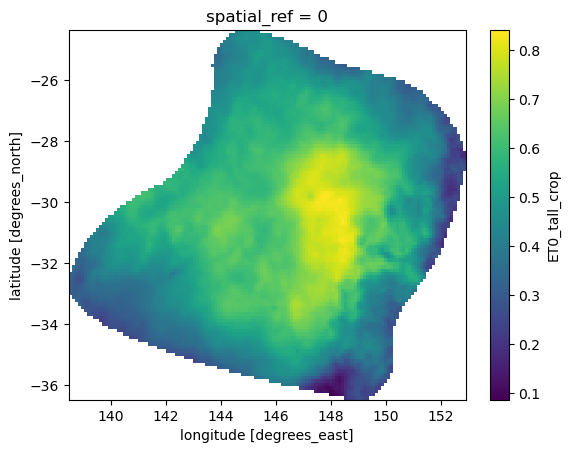

In [44]:
masked.sel(time=slice('2017', '2019')).mean(dim='time').plot()

In [54]:
plt.rcParams.update({'font.size': 16}) 

In [63]:
T_cont = (T_anom*sens_T.sel(doy=T_anom['time'].dt.dayofyear)).sel(time=slice('2016','2021'))
R_cont = (R_anom*sens_R.sel(doy=R_anom['time'].dt.dayofyear)).sel(time=slice('2016','2021'))
q_cont = (q_anom*sens_q.sel(doy=q_anom['time'].dt.dayofyear)).sel(time=slice('2016','2021'))
U_cont = (U_anom*sens_U.sel(doy=U_anom['time'].dt.dayofyear)).sel(time=slice('2016','2021'))

In [64]:
masked_T_cont = T_cont.rio.write_crs("EPSG:4326").rio.clip(
    gpd.read_file("/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp")
       .to_crs(T_cont.rio.write_crs("EPSG:4326").rio.crs).geometry, T_cont.rio.write_crs("EPSG:4326").rio.crs)

masked_R_cont = R_cont.rio.write_crs("EPSG:4326").rio.clip(
    gpd.read_file("/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp")
       .to_crs(R_cont.rio.write_crs("EPSG:4326").rio.crs).geometry, R_cont.rio.write_crs("EPSG:4326").rio.crs)

masked_q_cont = q_cont.rio.write_crs("EPSG:4326").rio.clip(
    gpd.read_file("/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp")
       .to_crs(q_cont.rio.write_crs("EPSG:4326").rio.crs).geometry, q_cont.rio.write_crs("EPSG:4326").rio.crs)

masked_U_cont = U_cont.rio.write_crs("EPSG:4326").rio.clip(
    gpd.read_file("/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp")
       .to_crs(U_cont.rio.write_crs("EPSG:4326").rio.crs).geometry, U_cont.rio.write_crs("EPSG:4326").rio.crs)


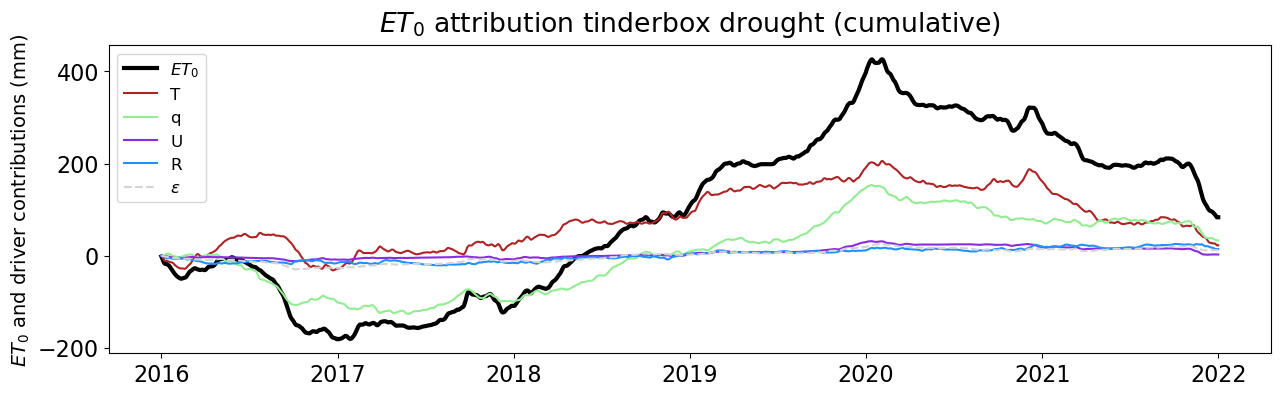

In [78]:
ET0_ts = masked.sel(time=slice('2016', '2021')).mean(dim=('lat','lon'))
T_ts = masked_T_cont.mean(dim=('lat','lon'))
q_ts = masked_q_cont.mean(dim=('lat','lon'))
R_ts = masked_R_cont.mean(dim=('lat','lon'))
U_ts = masked_U_cont.mean(dim=('lat','lon'))
closure_ts = ET0_ts - T_ts - q_ts - R_ts - U_ts
 
(ET0_ts.cumsum(dim='time')).plot(color='black', label='$ET_{0}$', figsize=(15,4), linewidth=3)
(T_ts.cumsum(dim='time')).plot(color='firebrick', label='T')
(q_ts.cumsum(dim='time')).plot(color='lightgreen', label='q')
(R_ts.cumsum(dim='time')).plot(color='blueviolet', label='U')
(U_ts.cumsum(dim='time')).plot(color='dodgerblue', label='R')
(closure_ts.cumsum(dim='time')).plot(color='lightgrey', linestyle='--', label=r"$\varepsilon$")
 
plt.title('$ET_{0}$ attribution tinderbox drought (cumulative)', pad=10)
plt.xlabel('')
plt.ylabel('$ET_{0}$ and driver contributions (mm)', fontsize=14)
plt.legend(fontsize=12)

## 'Celerity' of a flash drought – finding the flashiest flash droughts